In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the license plate image
img2 = cv2.imread('UKLicencePlateDataset/whiteplate_normal/AA03BOJ.png')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


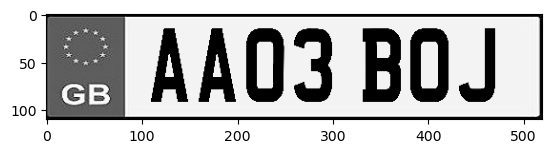

In [34]:
plt.imshow(gray,cmap='gray' )

In [35]:
#Maximize Contrast

structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

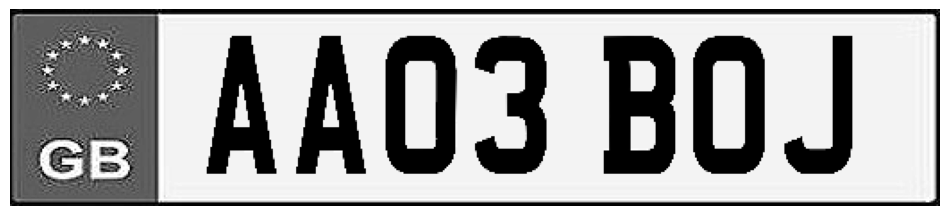

In [36]:

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.savefig('Car-Contrast.png',bbox_inches = 'tight')
plt.show()

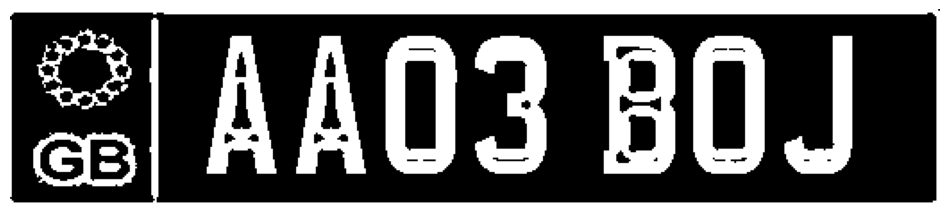

In [37]:
#Adaptive Thresholding

img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')
plt.axis('off')
#plt.savefig('Car-Adaptive-Thresholding.png',bbox_inches = 'tight')
plt.show()

In [38]:
height, width, channel = img.shape

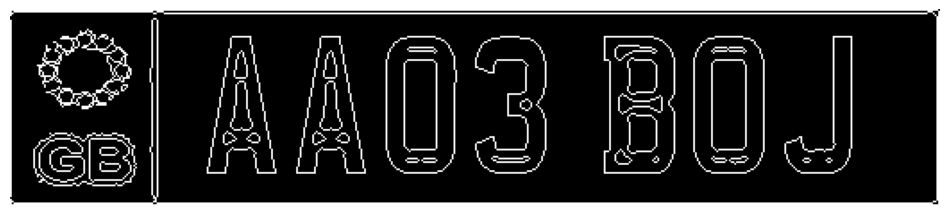

In [39]:
#Finding Contours to locate plate

contours, _= cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)
plt.axis('off')
#plt.savefig('Car-Contours.png',bbox_inches = 'tight')
plt.show()

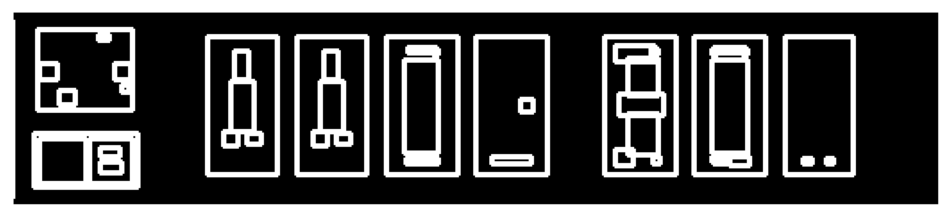

In [40]:
#Data Preparation

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
#plt.savefig('Car-Boxes.png',bbox_inches = 'tight')
plt.show()

In [41]:
#Selecting Boxes by Char Size

MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        

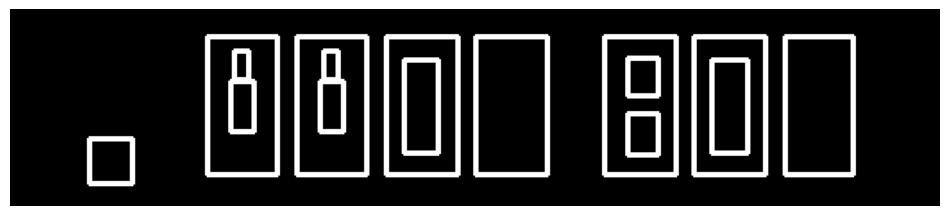

In [42]:
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#    cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('Car-Boxes-byCharSize.png',bbox_inches = 'tight')
plt.show()


In [43]:
#Selecting Boxes by Arrangement of Contours

MAX_DIAG_MULTIPLYER = 5 # 5
MAX_ANGLE_DIFF = 12.0 # 12.0
MAX_AREA_DIFF = 0.5 # 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3 # 3

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))


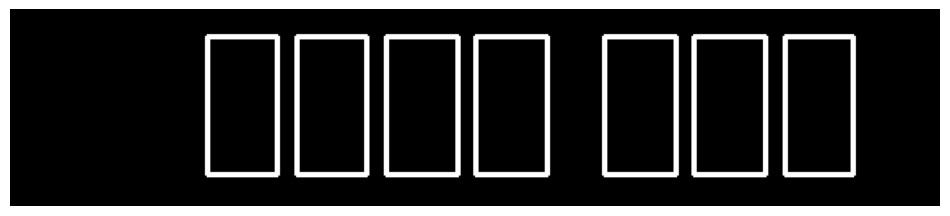

In [44]:

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
#plt.savefig('Car-Boxes-byContourArrangement.png',bbox_inches = 'tight')
plt.show()

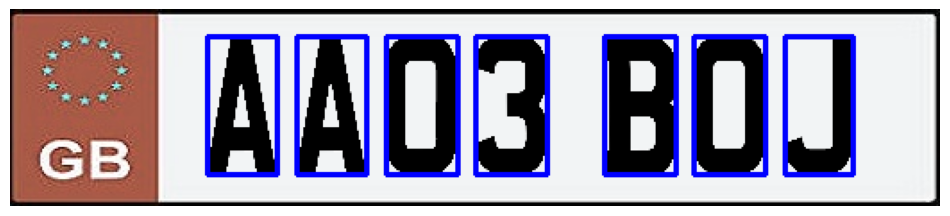

In [45]:

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(img, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(img, cmap='gray')
plt.axis('off')
#plt.savefig('Car-OverlappingBoxes.png',bbox_inches = 'tight')
plt.show()


In [46]:
from skimage.feature import hog

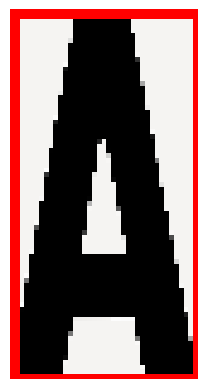

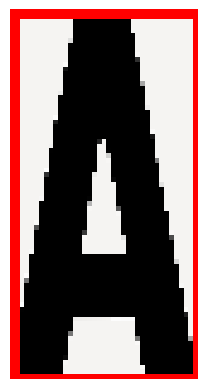

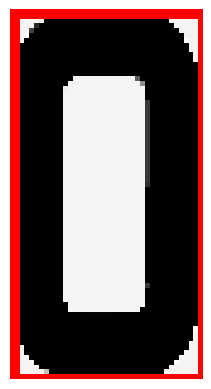

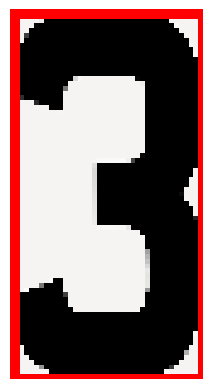

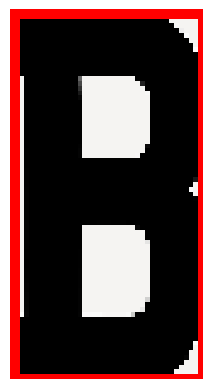

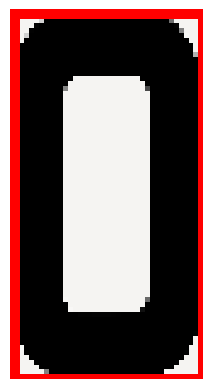

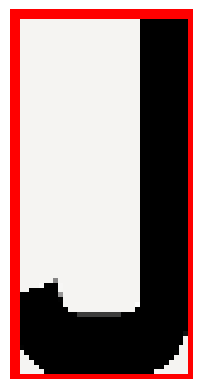

In [47]:
# Sort the contours based on their x-coordinate
sorted_result = sorted(matched_result, key=lambda x: x[0]['x'])

# Extract individual characters and crop the original image
for r in sorted_result:
    sorted_chars = sorted(r, key=lambda x: x['x'])  # Sort the characters in each row by x-coordinate
    for d in sorted_chars:
        x, y, w, h = d['x'], d['y'], d['w'], d['h']
        char_img = img[y:y+h, x:x+w]
        # ... (do something with the character image, e.g., save it, display it, process it, etc.)

        # Display the character image
        plt.imshow(cv2.cvtColor(char_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def preprocess(image):
    # Resize the image to 28x28
    img = cv2.resize(image, (28, 28))

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute the HOG features
    hog_features, hog_image = hog(gray_img, visualize=True, block_norm='L2-Hys')
    return hog_features

# ... (previous code for preprocessing and contour detection)

# Extract individual characters and preprocess
hog_features=[]
for r in matched_result:
    for d in r:
        x, y, w, h = d['x'], d['y'], d['w'], d['h']
        char_img = img[y:y+h, x:x+w]

        # Preprocess the character image
        hog_features.append(preprocess(char_img))
        

        # ... (do something with the preprocessed features, e.g., pass them to a machine learning model for classification)


In [49]:
hog_features

[array([0.2564741 , 0.04746444, 0.0378451 , 0.07783459, 0.04877519,
        0.        , 0.        , 0.        , 0.        , 0.03405395,
        0.04278121, 0.1116354 , 0.        , 0.31328019, 0.        ,
        0.        , 0.        , 0.        , 0.09577673, 0.        ,
        0.        , 0.        , 0.31328019, 0.        , 0.13199138,
        0.06245826, 0.04424875, 0.31328019, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.27243158, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.31328019, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.31328019,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.073751  , 0.17026974, 0.        ,
        0.        , 0.        , 0.31328019, 0.04588631, 0.06120277,
        0.03731401, 0.        , 0.31328019, 0.06

In [50]:
len(hog_features[1])

81

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def preprocess(image):
    # Resize the image to 28x28
    img = cv2.resize(image, (28, 28))

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute the HOG features
    hog_features, hog_image = hog(gray_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

    return hog_features

# ... (previous code for preprocessing and contour detection)

# Extract individual characters and preprocess
hog_features500=[]
for r in matched_result:
    for d in r:
        x, y, w, h = d['x'], d['y'], d['w'], d['h']
        char_img = img[y:y+h, x:x+w]

        # Preprocess the character image
        hog_features500.append(preprocess(char_img))
        

        # ... (do something with the preprocessed features, e.g., pass them to a machine learning model for classification)


In [52]:
len(hog_features500[1])

144

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def preprocess5(image):
    # Resize the image to 28x28
    img = cv2.resize(image, (28, 28))

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute the HOG features
    hog_features, hog_image = hog(gray_img, orientations=18, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')


    return hog_features

# ... (previous code for preprocessing and contour detection)

# Extract individual characters and preprocess
hog_features600=[]
for r in matched_result:
    for d in r:
        x, y, w, h = d['x'], d['y'], d['w'], d['h']
        char_img = img[y:y+h, x:x+w]

        # Preprocess the character image
        hog_features600.append(preprocess(char_img))
        

        # ... (do something with the preprocessed features, e.g., pass them to a machine learning model for classification)


In [55]:
len(hog_features600[1])

144

In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def preprocess(image):
    # Resize the image to 28x28
    img = cv2.resize(image, (70, 70))

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute the HOG features
    hog_features, hog_image = hog(gray_img, orientations=18, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

    return hog_features

# ... (previous code for preprocessing and contour detection)

# Extract individual characters and preprocess
hog_features600=[]
for r in matched_result:
    for d in r:
        x, y, w, h = d['x'], d['y'], d['w'], d['h']
        char_img = img[y:y+h, x:x+w]

        # Preprocess the character image
        hog_features600.append(preprocess(char_img))
        

        # ... (do something with the preprocessed features, e.g., pass them to a machine learning model for classification)


In [59]:
len(hog_features600[1])

18432

18432

In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def preprocess(image):
    # Resize the image to 28x28
    img = cv2.resize(image, (70, 70))

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute the HOG features
    hog_features, hog_image = hog(gray_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

    return hog_features

# ... (previous code for preprocessing and contour detection)

# Extract individual characters and preprocess
hog_features500=[]
for r in matched_result:
    for d in r:
        x, y, w, h = d['x'], d['y'], d['w'], d['h']
        char_img = img[y:y+h, x:x+w]

        # Preprocess the character image
        hog_features500.append(preprocess(char_img))
    

In [69]:
len(hog_features500[1])

1764

In [70]:
import os
import csv

# Specify the directory path where your images are stored
image_directory = 'UKLicencePlateDataset/whiteplate_normal'

# Get a list of image filenames in the directory
image_filenames = os.listdir(image_directory)

# Create a CSV file and write the header row
csv_filename = 'features667_size3_c.csv'
feature_names = [f'Feature{i+1}' for i in range(1764)]  # Replace 'Feature' with your desired feature name prefix
header_row = feature_names + ['Label']

# Counter variables
char_counts = {chr(i): 0 for i in range(48, 58)}  # Characters '0' to '9'
char_counts.update({chr(i): 0 for i in range(65, 91)})  # Characters 'A' to 'Z'

with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header_row)

    # Loop through the images
    for image_filename in sorted(image_filenames):
        # Assuming the image filename corresponds to the character labels
        char_img_name = os.path.splitext(image_filename)[0]  # Get the image name without extension

        # Load the image
        img = cv2.imread(os.path.join(image_directory, image_filename))

        # Perform character detection and get matched_result
        # ...
        # Your code for character detection goes here

        result_idx = find_chars(possible_contours)

        matched_result = []
        for idx_list in result_idx:
            matched_result.append(np.take(possible_contours, idx_list))

        # Sort the matched_result by x-coordinate to ensure left-to-right order
        sorted_result = sorted(matched_result, key=lambda x: x[0]['x'])

        temp_result = np.zeros((height, width, channel), dtype=np.uint8)

        for r in sorted_result:
            for d in r:
                cv2.rectangle(img, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

        #plt.figure(figsize=(12, 10))
        #plt.imshow(img, cmap='gray')
        #plt.axis('off')
        #plt.show()

        # Extract individual characters and preprocess
        hog_features = []
        labels = []

        for r in sorted_result:
            sorted_chars = sorted(r, key=lambda x: x['x'])  # Sort the characters in each row by x-coordinate
            for d in sorted_chars:
                x, y, w, h = d['x'], d['y'], d['w'], d['h']
                char_img = img[y:y+h, x:x+w]

                # Preprocess the character image
                feature = preprocess(char_img)
                hog_features.append(feature)

                # Extract the label based on the order of characters in the image name
                label = char_img_name[len(labels)]
                labels.append(label)

                # Update the character count and check the limit
                char_counts[label] += 1

                # Write the features and labels to the CSV file
                writer.writerow(list(hog_features[-1]) + [labels[-1]])

                # Check if the count for all characters reaches 100
                if all(count >= 100 for count in char_counts.values()):
                    break

            if all(count >= 100 for count in char_counts.values()):
                break

        if all(count >= 100 for count in char_counts.values()):
            break

    print(f"CSV file '{csv_filename}' created successfully.")


CSV file 'features667_size3_c.csv' created successfully.


In [71]:
import csv

# Specify the CSV file path
csv_filename = 'features667_size3_c.csv'

# Initialize character count dictionary
char_counts = {chr(i): 0 for i in range(48, 58)}  # Characters '0' to '9'
char_counts.update({chr(i): 0 for i in range(65, 91)})  # Characters 'A' to 'Z'

# Read the CSV file and count the occurrences of each character
with open(csv_filename, mode='r') as file:
    reader = csv.reader(file)
    header_row = next(reader)  # Skip the header row

    for row in reader:
        label = row[-1]  # Last element is the label

        # Increment the count for the character
        char_counts[label] += 1

# Print the character counts
for char, count in char_counts.items():
    print(f"Character '{char}': {count} samples")


Character '0': 172 samples
Character '1': 148 samples
Character '2': 171 samples
Character '3': 161 samples
Character '4': 183 samples
Character '5': 170 samples
Character '6': 164 samples
Character '7': 178 samples
Character '8': 165 samples
Character '9': 163 samples
Character 'A': 643 samples
Character 'B': 493 samples
Character 'C': 133 samples
Character 'D': 122 samples
Character 'E': 126 samples
Character 'F': 122 samples
Character 'G': 144 samples
Character 'H': 136 samples
Character 'I': 132 samples
Character 'J': 131 samples
Character 'K': 128 samples
Character 'L': 119 samples
Character 'M': 135 samples
Character 'N': 125 samples
Character 'O': 127 samples
Character 'P': 161 samples
Character 'Q': 143 samples
Character 'R': 156 samples
Character 'S': 127 samples
Character 'T': 116 samples
Character 'U': 126 samples
Character 'V': 100 samples
Character 'W': 105 samples
Character 'X': 112 samples
Character 'Y': 120 samples
Character 'Z': 109 samples


In [73]:
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load the CSV data
csv_filename = 'features667_size3_c.csv'
data = []
labels = []

with open(csv_filename, mode='r') as file:
    reader = csv.reader(file)
    header_row = next(reader)  # Skip the header row

    for row in reader:
        features = np.array(row[:-1], dtype=np.float32)  # Convert features to numpy array
        label = row[-1]
        data.append(features)
        labels.append(label)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Train the SVM classifier
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Accuracy: 0.9863713798977853


In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Predict 5 lines from the CSV file
num_predictions = 10
for i in range(num_predictions):
    features = np.array([X_test[i]], dtype=np.float32)
    expected_label = y_test[i]
    predicted_label = knn.predict(features)[0]
    print(f"Expected: {expected_label}, Predicted: {predicted_label}")


Accuracy: 0.9846678023850085
Expected: X, Predicted: X
Expected: H, Predicted: H
Expected: 5, Predicted: 5
Expected: Q, Predicted: Q
Expected: 0, Predicted: 0
Expected: I, Predicted: I
Expected: R, Predicted: R
Expected: 8, Predicted: 8
Expected: H, Predicted: H
Expected: D, Predicted: D


In [134]:
# Load the license plate image
img2 = cv2.imread('UKLicencePlateDataset/whiteplate_normal/ZM85AQB.png')

# Convert the image to grayscale
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


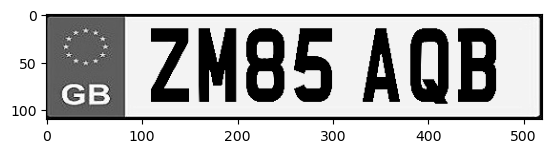

In [135]:
plt.imshow(gray,cmap='gray' )

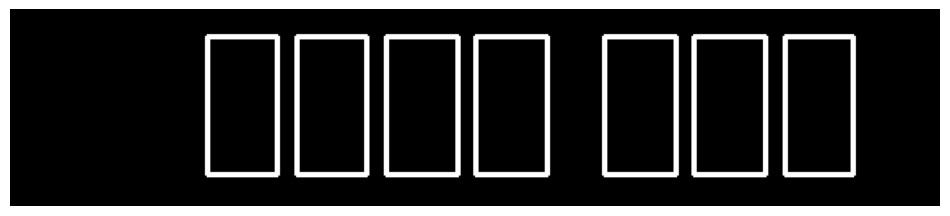

In [136]:

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
#plt.savefig('Car-Boxes-byContourArrangement.png',bbox_inches = 'tight')
plt.show()

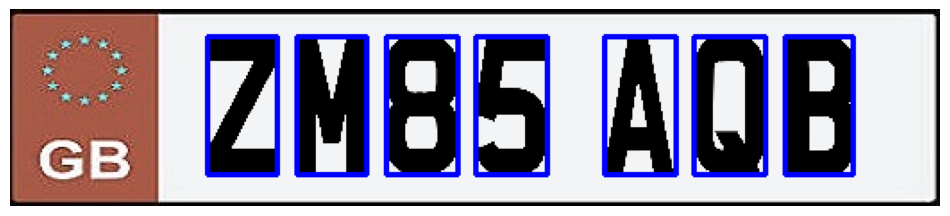

In [137]:

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(img2, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(img2, cmap='gray')
plt.axis('off')
#plt.savefig('Car-OverlappingBoxes.png',bbox_inches = 'tight')
plt.show()


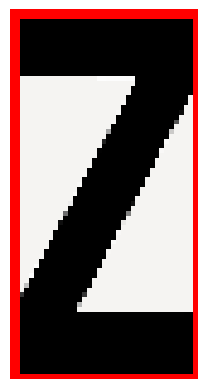

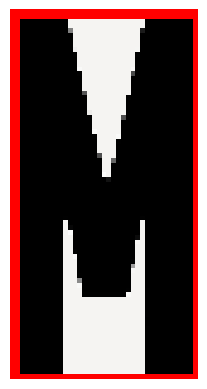

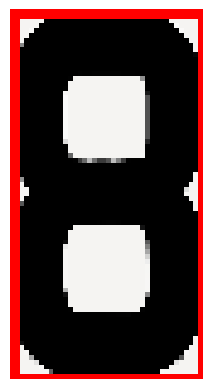

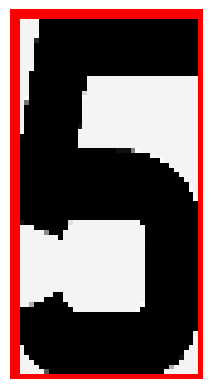

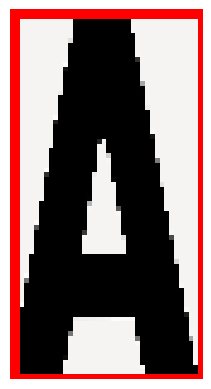

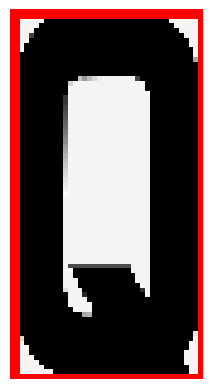

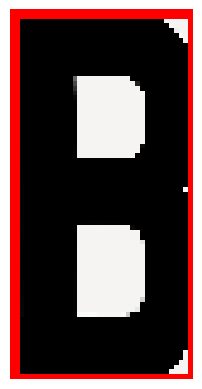

In [138]:
# Sort the contours based on their x-coordinate
sorted_result = sorted(matched_result, key=lambda x: x[0]['x'])

# Extract individual characters and crop the original image
for r in sorted_result:
    sorted_chars = sorted(r, key=lambda x: x['x'])  # Sort the characters in each row by x-coordinate
    for d in sorted_chars:
        x, y, w, h = d['x'], d['y'], d['w'], d['h']
        char_img = img2[y:y+h, x:x+w]
        # ... (do something with the character image, e.g., save it, display it, process it, etc.)
        # Preprocess the character image
        feature = preprocess(char_img)
        
        # Display the character image
        plt.imshow(cv2.cvtColor(char_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


In [139]:
import os

image_path = 'UKLicencePlateDataset/whiteplate_normal/ZM85AQB.png'
image_name = os.path.basename(image_path)
image_name_without_extension = os.path.splitext(image_name)[0]
char_img_name=image_name_without_extension
print(image_name_without_extension)


ZM85AQB


Predicted: Z, Expected: Z
Predicted: M, Expected: M
Predicted: 8, Expected: 8
Predicted: 5, Expected: 5
Predicted: A, Expected: A
Predicted: Q, Expected: Q
Predicted: B, Expected: B
Accuracy: 100.00%


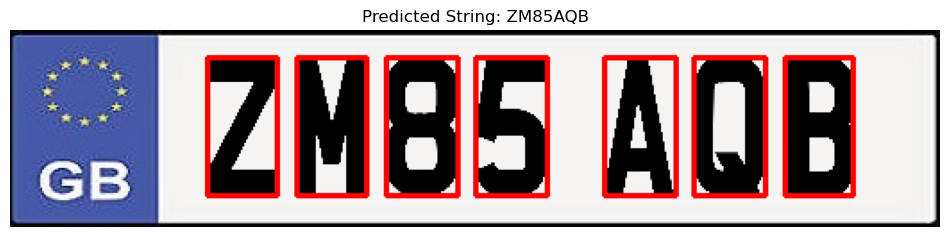

In [140]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess(image):
    # Resize the image to 28x28
    img = cv2.resize(image, (70, 70))

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute the HOG features
    hog_features, hog_image = hog(gray_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

    return hog_features

# Sort the contours based on their x-coordinate
sorted_result = sorted(matched_result, key=lambda x: x[0]['x'])

hog_features = []
labels = []

# Extract individual characters and crop the original image
for r in sorted_result:
    sorted_chars = sorted(r, key=lambda x: x['x'])  # Sort the characters in each row by x-coordinate
    for d in sorted_chars:
        x, y, w, h = d['x'], d['y'], d['w'], d['h']
        char_img = img2[y:y+h, x:x+w]
        
        # Preprocess the character image
        feature = preprocess(char_img)
        hog_features.append(feature)

        # Extract the label based on the order of characters in the image name
        label = char_img_name[len(labels)]
        labels.append(label)

# Convert the features and labels to arrays
hog_features = np.array(hog_features)
labels = np.array(labels)

# Make predictions using the KNN classifier
predicted_labels = knn.predict(hog_features)

# Display the predicted labels and the original characters
for i, pred_label in enumerate(predicted_labels):
    print(f"Predicted: {pred_label}, Expected: {labels[i]}")

# Convert the predicted labels to a string
predicted_string = ''.join(predicted_labels)
# Calculate the accuracy
correct_predictions = np.sum(predicted_labels == labels)
accuracy = correct_predictions / len(labels) * 100

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}%")

# Display the final image with predicted string
plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Predicted String: {predicted_string}")
plt.show()


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Recognized Text: 2h85AQB
Ground Truth: ZM85AQB
Accuracy: 0.7142857142857143


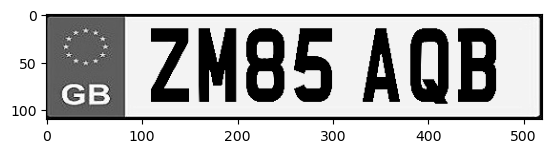

In [152]:
import easyocr
import cv2
import numpy as np

# Load the license plate image
img2 = cv2.imread('UKLicencePlateDataset/whiteplate_normal/ZM85AQB.png')

# Convert the image to grayscale
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Perform OCR using EasyOCR
reader = easyocr.Reader(['en'])
result = reader.readtext(gray)

# Extract the recognized text from the result
recognized_text = [text for (bbox, text, score) in result]

# Ground truth label
ground_truth = "ZM85AQB"
recognized_text_without_space = recognized_text[1].replace(' ', '')
# Calculate accuracy
correct_count = sum([1 for pred, gt in zip(recognized_text_without_space, ground_truth) if pred == gt])
accuracy = correct_count / len(ground_truth)

# Display the recognized text and accuracy
print("Recognized Text:", recognized_text_without_space)
print("Ground Truth:", ground_truth)
print("Accuracy:", accuracy)
plt.imshow(gray,cmap='gray' )